This code simulates a time-delay reservoir. It assesses the ability of the reservoir to predict the NARMA10, a chaotic timeseries. Included in this notebook is software to solve a delay differential equation. This software is included in two different functions as opposed to being modularized, because there are slight variations in the code in each function. This notebook is an early version of this simulation. Later versions include several optimizations and features added to handle large volumes of radio frequency data.

In [12]:
import numpy as np 
import sympy
import math
import matplotlib.pyplot as plt
import sklearn

import random
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn.linear_model import Ridge

In [22]:
# create values in the mask
def initialize_mask(dimension, scaling):
    """Arguments:
            dimension: length of the mask vector
            scaling: amplitude of an element of the mask vector
        Returns: 
            vector: the mask vector with the number of entries equal to the value of dimension"""
    vector = []
    choices = [-scaling, scaling]
    for i in range(dimension):
        vector.append(1) #random.choice(choices))
    return vector


# apply the mask to the input value
def mask(scalar_input, vector):
    """Arguments:
            scalar_input: value that will be masked
            vector: mask vector 
        Returns:
            output: masked version of the scalar_input"""
    output = [x * scalar_input for x in vector]
    return output
    


In [34]:
# use Moore-Penrose pseudo-inverse to assist training
def Moore_Penrose(target_vector, S):
    """Arguments:
            target_vector: desired output of the reservoir
            S: state matrix of the reservoir
        Returns:
            weights: describe how reservoir states should be combined"""
    dimension = len(target_vector)
    target_vector_transpose = np.transpose(target_vector)
    S_inverse = np.linalg.pinv(S) # Moore-Penrose pseudo-inverse
    weights = np.transpose(np.matmul(target_vector, S_inverse))
    return weights
    

# feed input into reservoir and solve delay differnetial equation (DDE)
def training_reservoir(𝛽, n, 𝜏, 𝛾, alpha, time_delta, N, u_vector, target_vector, bias):
    """Arguments:
            𝜏: delay length
            time_delta: time resolution
            N: number of nodes
            u_vector: input vector
            target_vector: desired output
            bias: account for potential bias of reservoir
       Returns:
            mask_vector: random mask to expand input dimensionality
            W: weight vector
            history_y: recent states of the DDE"""
    theta = 1.0 * 𝜏 / N
    k = len(u_vector)
    S = np.array([[0.0]  * k] * (N + 1)) # states
    mask_vector = initialize_mask(N, 0.1)  # create mask vector
    col = 0 # column
    row = 0 
    y_vector = []
    
    for u in u_vector: # loop through input
        if len(y_vector) == 0:
            y_vector = [0.01] * math.ceil(𝜏 / time_delta) #* resolution
        else:
            # load history
            y_vector = history_y
          
        index = 0
        row = 0 # reset row   
        # empty history
        history_y = []
        
        J_vector = mask(u, mask_vector) # compute masked version of input
        for j_scalar in J_vector:
            time_current = 0 # reset the time
            while time_current < theta:
                time_past = time_current - 𝜏
                y_scalar_past = y_vector[index]
         
                dy_scalar = 𝛽 * (y_scalar_past + alpha * j_scalar) / (1 + (y_scalar_past + alpha * j_scalar)**n) - 𝛾 * y_vector[-1] # compute derivative
                # integration
                current_y_scalar = y_vector[-1] + (dy_scalar * time_delta)
                y_vector.append(current_y_scalar)
                # history
                history_y.append(current_y_scalar)
                # increment time
                time_current += time_delta
                index += 1
    ###### Update virtual nodes #######
            S[row][col] = y_vector[-1] # fill matrix
            row += 1 
        col += 1 
    row = N 
    for col in range(k):
        S[row][col] = bias
    W = Moore_Penrose(target_vector, S)
    return (mask_vector, W, history_y)

In [35]:
def test_reservoir(𝛽, n, 𝜏, 𝛾, alpha, N, time_delta, u_vector, mask_vector, history_y, weights):
    """Arguments:
             𝜏: delay length
            time_delta: time resolution
            N: number of nodes
            u_vector: input vector
            target_vector: desired output
            bias: account for potential bias of reservoir
            mask_vector: random mask to expand input dimensionality
            history_y: recent states of the DDE
            weights: weight vector
        Returns:
            predictions: array with the prediction of the next value of the timeseries"""
    theta = 1.0 *  𝜏 / N
    virtual_nodes = [] # final states of virtual nodes
    k = len(u_vector)
    col = 0 # column
    row = 0
    

    
    y_vector = history_y
    predictions = [] # what the system outputs
    for u_scalar in u_vector: # loop through input
        
        if len(y_vector) == 0:
            y_vector = [1] * math.ceil(𝜏 / time_delta) #* resolution
        else:
            # load history
            y_vector = history_y

            # empty history
            history_y = []
        
        index = 0
        virtual_nodes = [] # internal states
        row = 0 # reset row
        J_vector = mask(u_scalar, mask_vector) # compute masked version of input
        for j_scalar in J_vector:
            time_current = 0 # reset the time
            while time_current < theta:
                time_past = time_current - 𝜏
                y_scalar_past = y_vector[index]
                dy_scalar = 𝛽 * (y_scalar_past + alpha * j_scalar) / (1 + (y_scalar_past + alpha * j_scalar)**n) - 𝛾 * y_vector[-1] # compute derivative
                # integration
                current_y_scalar = y_vector[-1] + dy_scalar * time_delta
                y_vector.append(current_y_scalar)
                
                # history
                history_y.append(current_y_scalar)
               
                # increment time
                time_current += time_delta
                index += 1
    
        ###### Update virtual nodes #######
            row += 1 # increment column
            virtual_nodes.append(y_vector[-1])
        col += 1 
        virtual_nodes.append(1) # for the bias
        predictions.append(np.dot(virtual_nodes, weights))
    return np.array(predictions)

In [36]:
# creates next value of NARMA10 series
def narma10(y, u):
    """Arguments:
            y: vector with values of timesereis
            u: vector with random values that influenc timeseries output
        Returns:
            None"""
    value = 0.5 * random.random()
    u.append(value)
    max_index = len(y) - 1
    if max_index < 9: # cannot look back 10 steps
        y.append(0)
        return 0
    
    # look back and do actual stuff
    prev_y = y[max_index]
    prev_u = u[max_index]
    output = 0.3 * prev_y  + 0.05 * prev_y * sum(y[max_index - 9: max_index + 1]) + 1.5 * prev_u * u[max_index - 9] + 0.1
    y.append(output)
    




# narma but with the number of previous items being summed depending on the current value of u
def narma_variable_lookback(y, u, threshold):
    """Arguments:
            y: vector with values of timesereis
            u: vector with random values that influenc timeseries output
            threshold: determine how far to look back
        Returns:
            None"""
    value = 0.5 * random.random()
    if value >= threshold: # lookback 20
        begin = 25
    else:
        begin = 9 # lookback 10
        
    u.append(value)
    max_index = len(y) - 1
    if max_index < 39: # cannot look back 10 steps
        y.append(0)
        return 0
    
    # look back and do actual stuff
    prev_y = y[max_index]
    prev_u = u[max_index]
    output = 0.3 * prev_y  + 0.05 * prev_y * sum(y[max_index - begin: max_index - begin + 10]) + 1.5 * prev_u * u[max_index - begin] + 0.1
    y.append(output)



# Normalized Root Mean Square Error
def nrmse(y_vec, target, m): 
    """Arguments:
            y_vec: vector output of reservoir
            target: desired output of reservoir
            m: length of output
        Returns: 
            NRSME: normalized root mean squared error"""
    variance = np.var(target)
    squared_error = 0
    for i in range(len(y_vec)):
        squared_error += (y_vec[i] - target[i]) ** 2
    NRMSE = np.sqrt(squared_error / (m * variance))
    return NRMSE












In [37]:
##### actual training and test on NARMA10 ########

##### parameters #####
n = 1 #1
𝛽 = 0.5 
𝛾 = 0.8 
alpha = 0.05
𝜏 = 80 
N = 400
bias = 1.0 
time_delta = 0.001


##### training data #########
target_vector = []
u_vector = []
for i in range(3000):
    narma10(target_vector, u_vector)


mask_vector, weights, history_y = training_reservoir(𝛽, n, 𝜏, 𝛾, alpha, time_delta, N, u_vector, target_vector, bias)



###### testing ############
for i in range(400):
    narma10(target_vector, u_vector)


predictions = test_reservoir(𝛽, n, 𝜏, 𝛾, alpha, N, time_delta, u_vector[3000:3400], mask_vector, history_y, weights)
print("#######The Error########")
print(nrmse(target_vector[3000:3400], predictions, len(target_vector[3000:3400])))




#######The Error########
0.49463139405709466


400


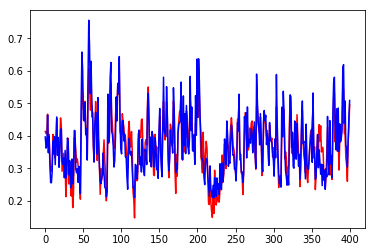

400
0.49463139405709466


In [38]:
#### plot actual NARMA10 and prediction ####
print(len(target_vector[3000:3400]))
plt.plot(np.linspace(0, 400, 400), predictions, color = "red")
#plt.show()
plt.plot(np.linspace(0, 400, 400), target_vector[3000:3400], color = "blue")
plt.show()
print(len(predictions))
print(nrmse(target_vector[3000:3400], predictions, len(target_vector[3000:3400])))